# Numerical Optimization
Learn to solve non-convex multi-dimensional optimization problems using numerical optimization with multistart and nesting (**scipy.optimize**). Learn simple function approximation using linear interpolation (**scipy.interp**).

**Links:**

1. **scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
2. **scipy.interp:** [overview](https://docs.scipy.org/doc/scipy/reference/interpolate.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

In [1]:
from types import SimpleNamespace
import time
import numpy as np 
import scipy as sp 
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Introduction
All **optimization problems** are characterized by:

1. Control vector (if model then it is choices), $\boldsymbol{x} \in \mathbb{R}^k$
2. Objective function (payoff, utility) to minimize, $f:\mathbb{R}^k \rightarrow \mathbb{R}$ (differentiable or not)
3. Constraints, i.e. $\boldsymbol{x}  \in C \subseteq \mathbb{R}^k$ (linear or non-linear interdependence)

Note that $f$ might also take other inputs (parameters or a dataset), but these are fixed, and therefore not variables we optimize over.

**Maximization** is just **minimization** of $-f$. 

### Structure
All **optimizers** (minimizers) follow the structure:

1. Make initial guess
2. Evaluate the function (and perhaps gradients)
3. Check for convergence
4. Update guess and return to step 2

**Convergence:** "Small" change in function value since last iteration (or "zero" gradient).

### Characteristics
**Characteristics** of optimizers:

1. Use gradients or not.
2. Allow for specifying bounds.
3. Allow for specifying general constraints.

**Gradients** provide useful information (e.g. on shape of function), but can be costly to compute (using analytical formula or numerically).

**Penalty terms** can (sometimes) instead be used to enforce bounds and constraints.

### Different optimizers
**Optimizers** you should know:

1. **Nelder-Mead - The Go To optimizer:** 
 * **Pro:** Robust (to e.g. noise in objective function) and does not require derivatives.
     - smooth meaning enough continous derivatives
 * **Con:** Slow convergence. No bounds or constraints.
2. **Newton-CG:**
 * **Pro:** Require few iterations. Very precise with analytical hessian for smooth functions.
 * **Con:** Costly computation of hessian. No bounds or constraints.
3. **BFGS:** (like newton, but with smart computation of hessian)
  * **Pro:** Require few function evaluations. 
  * **Con:** No bounds or constraints.
4. **L-BFGS-B:** Like BFGS, but allows for bounds.
5. **SLSQP:**
  * **Pro:** Bounds and constraints in multiple dimensions.
  * **Con:** Not as efficient as BFGS.

## Gradient Based Optimizers
Let's look at the idea behind gradient based optimizers.

**One dimensional intuition:** Consider the second-order Taylor approximation around $x_n$:

$$ 
f_T(x) = f_T(x_n + \Delta x) \approx f(x_n)+ f^{\prime}(x_n) \Delta x + \frac{1}{2} f^{\prime\prime}(x_n) (\Delta x)^2
$$

This allows us to approximate any continuous function as a polynomial!

Find the minimum wrt. to $\Delta x$ by solving the FOC:

$$
0 = \frac{d}{d\Delta x} f_T(x) = f^{\prime}(x_n) + f^{\prime\prime}(x_n) \Delta x \Leftrightarrow \Delta x = -\frac{f^{\prime}(x_n)}{f^{\prime\prime}(x_n)}
$$

We simply solve for input, which gives output zero!

## Second order optimization algorithm: Newton's Method 
- second order method, therefore, we approximate using a quadratic polynomial and then minimize that
    - second order derivative (Hessian in multivariable case) as opposed to gradient descent
    
- compared to gradient descent a second order approzimation can be much faster
- remember, Hessian must be invertible
    - therefore, for convergence to stationary point we need to start closely enough
    - if function is convex, then local minimum is global

**Algorithm:** `minimize_newton()`

1. Choose tolerance $\epsilon>0$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $n=1$.
2. Compute $\nabla f(\boldsymbol{x}_{n-1})$ (gradient: the vector of first order partial derivatives/ equivalent of the gradient for vector valued functions,jacobian) and $\boldsymbol{H}f(\boldsymbol{x}_{n-1})$ (hessian).
3. Compute new guess

  $$
  \nabla f(x_{n-1}+\Delta x) \approx \nabla f(x_{n-1})+\boldsymbol{H}f(x_{n-1})\Delta x \\
  \nabla f(x_{n-1})+\boldsymbol{H}f(x_{n-1})\Delta x = 0 \\
  \boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - [\boldsymbol{H}f(\boldsymbol{x}_{n-1})]^{-1} \nabla f(\boldsymbol{x}_{n-1})
  $$

3. If $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon$ then stop (i.e. if minimum found).
5. Set $n = n + 1$ and return to step 2.

In [2]:
def minimize_newton(f, x0, jac, hess, max_iter=500, tol=1e-8):
    """ minimize function with Newton's algorithm 
    
    Args:
    

        f (callable): function
        x0 (np.ndarray): initial values # multidimensional array of fixed initial values
        jac (callable): jacobian
        hess (callable): hessian
        max_iter (int): maximum number of iterations
        tol (float): tolerance

    Returns:
    
        x (np.ndarray): minimum
        n (int): number of iterations used
    
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    n = 1 
    
    # step 2-5: iterations 
    while n < max_iter: 
        
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient and hessian
        jacx = jac(x_prev)
        hessx = hess(x_prev) # think of hessx as the "gradient of the gradient"
        
        # step 3: update x 
        inv_hessx = linalg.inv(hessx)
        x = x_prev - inv_hessx@jacx 
        
        # step 4: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break 
            
        # step 5: increment n
        n += 1
        print(x,jacx) # allows us to see how newton method works in section below contour plot
        
    return x,n 

# First order optimization algorithm: Gradient descent



## Gradient descent the simple way (i.e. constant step size)
**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, step size $\alpha > 0$, and guess on $x_0$, set $n=0$.
2. Compute  $f(x_n)$ and $f^\prime(x_n) \approx \frac{f(x_n+\Delta)-f(x_n)}{\Delta}$.
3. If $|f^\prime(x_n)| < \epsilon$ then stop (zero derivative).
4. Compute new guess "down the hill":

  $$
  x_{n+1} = x_{n} - \alpha f^\prime(x_n)
  $$


5. Set $n = n + 1$ and return to step 2.

**Code for algorithm:**

In [67]:
def gradient_descent(f,x0,alpha=0.5,Delta=1e-8,max_iter=500,eps=1e-8): # max_iter makes sure computer doesn't run forever
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (float): initial value
        alpha (float,optional): step size factor in search (learning rate)
        Delta (float,optional): step size in numerical derivative
        max_iter (int,optional): maximum number of iterations
        eps (float,optional): tolerance
        
    Returns:
    
        x (float): minimum
        fx (float): function value at minimum
        trials (list): og dicts with keys x, value and derivative
        
    """
    
    # step 1: initialize (pick random value, such 
    # that gradient descent thas something to improve upon)
    x = x0
    n = 0
    trials = [] # create empty list
    
    # step 2-4:
    while n < max_iter: # as long as n is smaller than max iteration continue loop
            
        # step 2: compute function value and derivative
        fx = f(x)
        fp = (f(x+Delta)-fx)/Delta 
        
        # add key/value pairs to trial list
        trials.append({'x':x,'fx':fx,'fp':fp}) 
        
        # step 3: check convergence
        # print each iteration, x value, f value and derivative
        print(f'n = {n:3d}: x = {x:12.8f}, f = {fx:12.8f}, fp = {fp:12.8f}')
        if np.abs(fp) < eps:
            break            # go out of while loop
                  
        # step 4: update x
        # x = x_prev - (learning-rate) * gradient
        x -= alpha*fp        # i.e. x = x - alpha*fp
        
        # step 5: increment n each time
        n += 1
    
    if n == max_iter:
        print('Gradient descent does not converge.')
    else:
        print(f'\nBest with gradient_descent is {fx:.8f} at x = {x:.8f}')
        
    return x,fx,trials

### Example:

$$
\max_x f(x) = \max_x -\sin(x)+0.05x^2
$$

**Call the optimizer:**

In [68]:
x0 = 0.0 # <-- initialize 
# choose learning rate
alpha = 0.5 # e.g. x start value is 0 then next is 0.5 an so forth

# set a function
f = lambda x: -np.sin(x)+0.05*x**2

# unpack solution
x,fx,trials = gradient_descent(f,x0,alpha)

n =   0: x =   0.00000000, f =   0.00000000, fp =  -1.00000000
n =   1: x =   0.50000000, f =  -0.46692554, fp =  -0.82758257
n =   2: x =   0.91379128, f =  -0.75007422, fp =  -0.51936898
n =   3: x =   1.17347577, f =  -0.85324884, fp =  -0.26960143
n =   4: x =   1.30827649, f =  -0.88015974, fp =  -0.12868722
n =   5: x =   1.37262010, f =  -0.88622298, fp =  -0.05961956
n =   6: x =   1.40242988, f =  -0.88751934, fp =  -0.02732913
n =   7: x =   1.41609444, f =  -0.88779134, fp =  -0.01247610
n =   8: x =   1.42233249, f =  -0.88784799, fp =  -0.00568577
n =   9: x =   1.42517538, f =  -0.88785975, fp =  -0.00258930
n =  10: x =   1.42647003, f =  -0.88786219, fp =  -0.00117876
n =  11: x =   1.42705941, f =  -0.88786269, fp =  -0.00053655
n =  12: x =   1.42732768, f =  -0.88786280, fp =  -0.00024419
n =  13: x =   1.42744978, f =  -0.88786282, fp =  -0.00011114
n =  14: x =   1.42750535, f =  -0.88786283, fp =  -0.00005059
n =  15: x =   1.42753065, f =  -0.88786283, fp =  -0.0

**Illustration:**

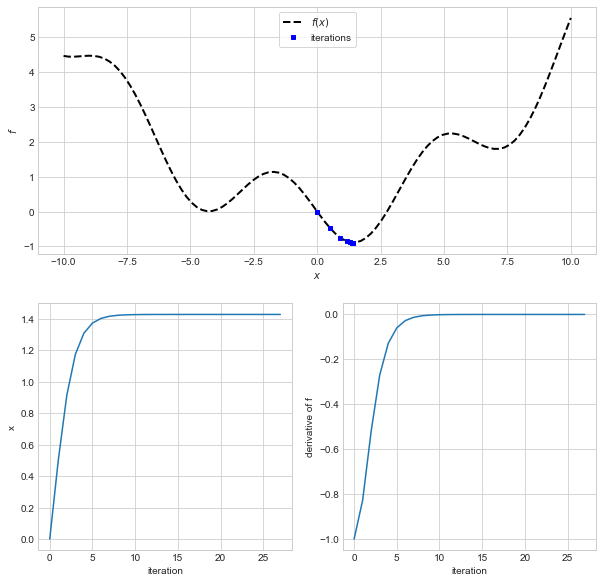

In [69]:
# Always start with the "canvas"
fig = plt.figure(figsize=(10,10))

# a. main figure
ax = fig.add_subplot(2,2,(1,2))

trial_x_vec = [trial['x'] for trial in trials]
trial_f_vec = [trial['fx'] for trial in trials]
trial_fp_vec = [trial['fp'] for trial in trials]

x_vec=np.linspace(-10,10,100)
ax.plot(x_vec,f(x_vec),ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(trial_x_vec,trial_f_vec,ls='',marker='s',ms=4,color='blue',label='iterations') # blue dots show iterations

ax.set_xlabel('$x$')
ax.set_ylabel('$f$')
ax.legend(loc='upper center',frameon=True)

# sub figure 1
ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(len(trials)),trial_x_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('x')

# sub figure 2
ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(len(trials)),trial_fp_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('derivative of f');

#### Example of no converge

n =   0: x =   0.00000000, f =   0.00000000, fp =  -1.00000000
n =   1: x =   0.00050000, f =  -0.00049999, fp =  -0.99994987
n =   2: x =   0.00099997, f =  -0.00099992, fp =  -0.99989950
n =   3: x =   0.00149992, f =  -0.00149981, fp =  -0.99984888
n =   4: x =   0.00199985, f =  -0.00199965, fp =  -0.99979801
n =   5: x =   0.00249975, f =  -0.00249943, fp =  -0.99974690
n =   6: x =   0.00299962, f =  -0.00299917, fp =  -0.99969554
n =   7: x =   0.00349947, f =  -0.00349885, fp =  -0.99964393
n =   8: x =   0.00399929, f =  -0.00399848, fp =  -0.99959207
n =   9: x =   0.00449909, f =  -0.00449806, fp =  -0.99953997
n =  10: x =   0.00499886, f =  -0.00499759, fp =  -0.99948762
n =  11: x =   0.00549860, f =  -0.00549706, fp =  -0.99943502
n =  12: x =   0.00599832, f =  -0.00599648, fp =  -0.99938218
n =  13: x =   0.00649801, f =  -0.00649585, fp =  -0.99932909
n =  14: x =   0.00699767, f =  -0.00699517, fp =  -0.99927575
n =  15: x =   0.00749731, f =  -0.00749443, fp =  -0.9

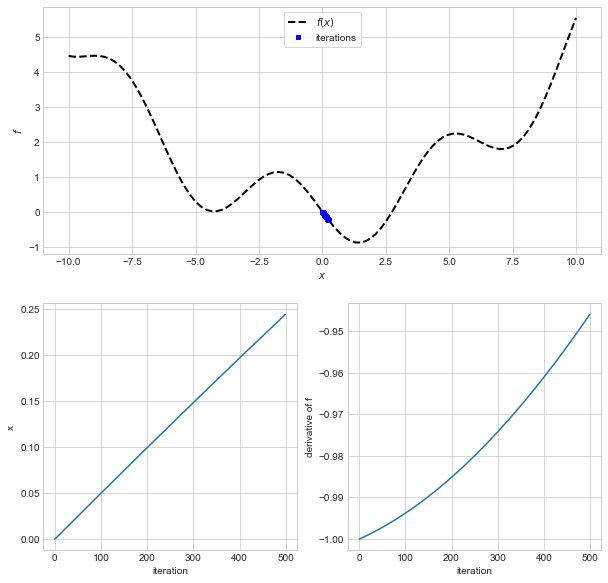

In [77]:
# example 1
x,fx,trials = gradient_descent(f,x0,alpha=0.0005)

# Always start with the "canvas"
fig = plt.figure(figsize=(10,10))

# a. main figure
ax = fig.add_subplot(2,2,(1,2))

trial_x_vec = [trial['x'] for trial in trials]
trial_f_vec = [trial['fx'] for trial in trials]
trial_fp_vec = [trial['fp'] for trial in trials]

x_vec=np.linspace(-10,10,100)
ax.plot(x_vec,f(x_vec),ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(trial_x_vec,trial_f_vec,ls='',marker='s',ms=4,color='blue',label='iterations') # blue dots show iterations

ax.set_xlabel('$x$')
ax.set_ylabel('$f$')
ax.legend(loc='upper center',frameon=True)

# sub figure 1
ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(len(trials)),trial_x_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('x')

# sub figure 2
ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(len(trials)),trial_fp_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('derivative of f');

- the step length is so small so that the number of iterations is maxed out. 
- Increasing `max_iter` wll solve the issue even though it will take much longer to arrive at the solution.

n =   0: x =   0.00000000, f =   0.00000000, fp =  -1.00000000
n =   1: x =   2.00000000, f =  -0.70929743, fp =   0.61614684
n =   2: x =   0.76770631, f =  -0.66501810, fp =  -0.64273485
n =   3: x =   2.05317602, f =  -0.67511693, fp =   0.66920625
n =   4: x =   0.71476353, f =  -0.62989449, fp =  -0.68377191
n =   5: x =   2.08230734, f =  -0.65520568, fp =   0.69772615
n =   6: x =   0.68685503, f =  -0.61052000, fp =  -0.70455859
n =   7: x =   2.09597221, f =  -0.64558080, fp =   0.71096241
Gradient descent does not converge.


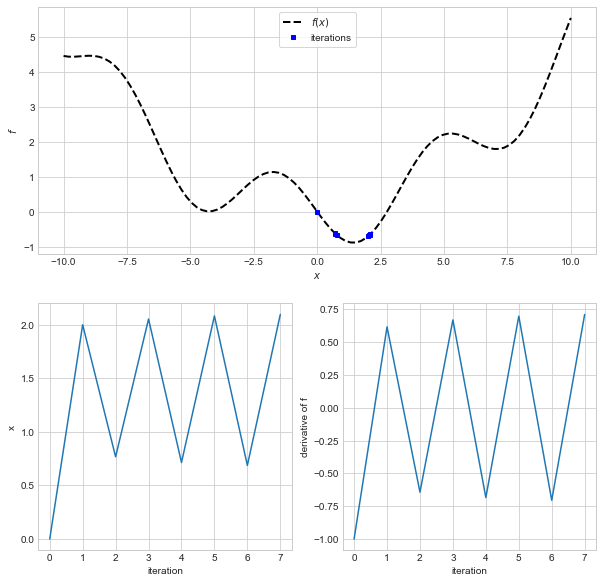

In [76]:
# example 2
x,fx,trials = gradient_descent(f,x0,alpha=2, max_iter=8)

# Always start with the "canvas"
fig = plt.figure(figsize=(10,10))

# a. main figure
ax = fig.add_subplot(2,2,(1,2))

trial_x_vec = [trial['x'] for trial in trials]
trial_f_vec = [trial['fx'] for trial in trials]
trial_fp_vec = [trial['fp'] for trial in trials]

x_vec=np.linspace(-10,10,100)
ax.plot(x_vec,f(x_vec),ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(trial_x_vec,trial_f_vec,ls='',marker='s',ms=4,color='blue',label='iterations') # blue dots show iterations

ax.set_xlabel('$x$')
ax.set_ylabel('$f$')
ax.legend(loc='upper center',frameon=True)

# sub figure 1
ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(len(trials)),trial_x_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('x')

# sub figure 2
ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(len(trials)),trial_fp_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('derivative of f');

- scenario diverges due to the big step length. 
- Here, we set `max_iter` = 8 to make the visualization more pleasing.

## Gradient descent the hard way (line search to determine step size)
Now, what could we improve from our gradient descent algorithm? We see previously that the step length α is maintained constant throughout the steps and the wrong choice of α might end up diverges the steps. Could we search for the optimum α for each step direction? \
... Enter *line search*.

**Line search:**
In the line search strategy, the algorithm chooses a direction $p_{n-1}$ (could e.g. be the steepest descent $-\nabla f(\boldsymbol{x}_{n-1}))$ and searches along this direction from the current iterate xₖ for a new iterate with a lower function value. The distance to move along pₖ can be found by approximately solving the following one-dimensional minimization problem to find a step length α:
$$
\min_{\alpha \in \boldsymbol{\alpha}} f(\boldsymbol{x}_{n-1} - \alpha \nabla f(\boldsymbol{x}_{n-1}))
$$

**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, potential step sizes, $ \boldsymbol{\alpha} = [\alpha_0,\alpha_1,\dots,\alpha_\#]$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $n=1$.
2. Compute $\nabla f(\boldsymbol{x}_{n-1})$.
3. Find good step size:

  $$ 
  \alpha^{\ast} = \arg \min_{\alpha \in \boldsymbol{\alpha}}  f(\boldsymbol{x}_{n-1} - \alpha \nabla f(\boldsymbol{x}_{n-1}))
  $$

4. Compute new guess:

  $$
  \boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - \alpha^{\ast} \nabla f(\boldsymbol{x}_{n-1})
  $$

5. If $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon$ then stop.
    - below threshold --> done
6. Set $n = n + 1$ and return to step 2.

In [78]:
def minimize_gradient_descent(f,x0,jac,alphas=[0.01,0.05,0.1,0.25,0.5,1],max_iter=500,tol=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (np.ndarray): initial values
        jac (callable): jacobian
        alpha (list): potential step sizes # note gradient descent takes big steps when 
        far away from optimal value and small steps when close
        
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (np.ndarray): minimum
        n (int): number of iterations used
        
    """
    
    # step 1: initialize
    x = x0 # gives gradient descent something to improve upon
    fx = f(x0)
    n = 1
    
    # step 2-6: iteration
    while n < max_iter:
            
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient
        jacx = jac(x)
        
        # step 3: find good step size (line search) by varying alpha
        fx_ast = np.inf # x_ast is best x seen
        alpha_ast = np.nan # best alpha seen
        for alpha in alphas: 
            x = x_prev - alpha*jacx
            fx = f(x)
            if fx < fx_ast: # can also change to fx < fx_prev if we dont want to evalute against all alphas
                fx_ast = fx # best x seen
                alpha_ast = alpha
        
        # step 4: update guess
        x = x_prev - alpha_ast*jacx
                            
        # step 5: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # d. update i
        n += 1

        
    return x,n

**Many generalizations:**

1. Use both Hessian and line search
2. Stop line search when improvement found
3. Limit attention to a "trust-region"

### Example: The rosenbrock function
Consider the **rosenbrock function**, which is the common function to illustrate unconstraint optimization problems:

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) =0.5(1-x_{1})^{2}+(x_{2}-x_{1}^{2})^{2}
$$

with **jacobian** (gradient)
- remember the gradient is a way of packing away all the partial derivative information of a function
    - in the case of a scalar function
- The Jacobian matrix is the matrix formed by the partial derivatives of a vector function. Its vectors are the gradients of the respective components of the function.
    - Jacobian is used in the the case of vector functions (i.e. a generalization) 

$$ 
\nabla f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}}\\
\frac{\partial f}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}-(1-x_{1})-4x_{1}(x_{2}-x_{1}^{2})\\
2(x_{2}-x_{1}^{2})
\end{bmatrix}
$$

and **hessian** (generalizaiton of second derivative):

$$
\boldsymbol{H}f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}x_{1}} & \frac{\partial f}{\partial x_{1}x_{2}}\\
\frac{\partial f}{\partial x_{1}x_{2}} & \frac{\partial f}{\partial x_{2}x_{2}}
\end{bmatrix}=\begin{bmatrix}1-4x_{2}+12x_{1}^{2} & -4x_{1}\\
-4x_{1} & 2
\end{bmatrix}
$$

**Note:** Minimum is at $(1,1)$ where $f(1,1)=0$.

**Check jacobian and hessian:**

In [79]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = 0.5*(1-x1)**2+(x2-x1**2)**2

In [80]:
df = sm.Matrix([sm.diff(f,i) for i in [x1,x2]]) # take derivates using diff
df

Matrix([
[-4*x_1*(-x_1**2 + x_2) + 1.0*x_1 - 1.0],
[                     -2*x_1**2 + 2*x_2]])

In [81]:
hf = sm.Matrix([[sm.diff(f,i,j) for j in [x1,x2]] for i in [x1,x2]])
hf

Matrix([
[12*x_1**2 - 4*x_2 + 1.0, -4*x_1],
[                 -4*x_1,      2]])

**Implementation** of functions:

In [82]:
def _rosen(x1,x2):
    return 0.5*(1.0-x1)**2+(x2-x1**2)**2
def rosen(x):
    return _rosen(x[0],x[1]) # we vectorize the function
def rosen_jac(x):
    return np.array([-(1.0-x[0])-4*x[0]*(x[1]-x[0]**2),2*(x[1]-x[0]**2)]) # values from df
def rosen_hess(x):
    return np.array([[1-4*x[1]+12*x[0]**2,-4*x[0]],[-4*x[0],2]]) # values from hf

**3D Plot:**

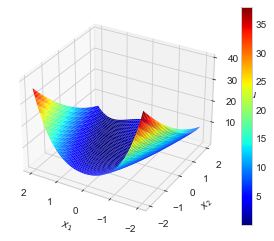

In [83]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij') # create grid out of array values for x1 and x2
rosen_grid = _rosen(x1_grid,x2_grid) # rosenbrock values at different grid points

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,rosen_grid,cmap=cm.jet) # our z argument is the rosenbrock function values at the different grid points

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis() # changes axis of x1

# e. add colorbar
fig.colorbar(cs);

**Contour plot:**

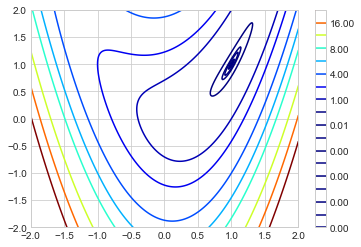

In [84]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
cs = ax.contour(x1_grid,x2_grid, rosen_grid, levels=levels, cmap=cm.jet)
fig.colorbar(cs);

**Newton:**

In [85]:
x0 = np.array([5,4]) # initial guess
x,n = minimize_newton(rosen,x0,rosen_jac,rosen_hess)
print(n,x,rosen(x))

[ 4.95294118 24.52941176] [424. -42.]
[  1.03470822 -14.28192837] [ 3.99681498 -0.00442907]
[1.03415209 1.06947024] [ 63.57634497 -30.70509896]
[1.00000004 0.99883372] [ 3.41533714e-02 -6.18562555e-07]
[1. 1.] [ 0.00466549 -0.00233273]
6 [1. 1.] 0.0


**Gradient Descent (hard way)**:

In [86]:
x0 = np.array([5,4])
x,n = minimize_gradient_descent(rosen,x0,rosen_jac,alphas=[0.01,0.05,0.1,0.25,0.5,1])
print(n,x,rosen(x)) # doesn't find exact minimum and takes longer

173 [1.00020519 1.00053964] 3.7750814497569406e-08


**Questions:** Any ideas for getting the gradient descent optimizer to converge faster?

In [87]:
# we can change step size
x0 = np.array([5,4])
x,n = minimize_gradient_descent(rosen,x0,rosen_jac,alphas=[0.01,0.03,0.05,0.1,0.25,0.5,1])
print(n,x,rosen(x))

159 [1.00033643 1.00073416] 6.033687455304422e-08


## Scipy minimizers
**Preperation I:** Function for collecting infomation while running optimizing:

In [ ]:
# complicated -> not necessary to understand it
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [rosen(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(rosen(x))
    
    # c. increment number of evaluations
    evals += 1

**Preperation II:** Function plotting the collected information:

In [ ]:
# complicated -> not necessary to understand it
def contour():
    
    #if you use the global statement, the variable will become available "outside"
    # the scope of the function, effectively becoming a global variable.
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
    cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

**Nelder-Mead**

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='Nelder-Mead',
                           callback=collect, # call collect() before each iteration
                           options={'disp':True}) # display the results
contour()

> **Note:** Does not require a gradient. Slow convergence close to target.
>
> **Iterations:** How many steps the algorithm has taken.
>
> **Function evaluations:** Will be higher than iterations. Used to compute next step.

We can also **print the information on results:**

In [ ]:
print(result)

We can also acess specific information of the result object: 

In [ ]:
result.nit

**Newton** (with analytical hessian)

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,hess=rosen_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Smoother and faster.

**Newton** (with numerical hessian computed by scipy)

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac, # calculates hessian numerically, becasue we do not supply it
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but gradient evaluations instead of hessian evaluations.

**BFGS** (with analytical gradient)

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Non-smooth, but fast. Very low number of function evaluations.

**BFGS** (with numerical gradient computed by scipy)

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0, # no jac= specified
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but more function evaluations.

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='L-BFGS-B',
                           bounds=((-3,3),(-3,3)),
                           callback=collect,
                           options={'disp':True})
contour()

**SLSQP**

In [ ]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='SLSQP',
                           bounds=((-2,2),(-2,2)),
                           callback=collect,
                           options={'disp':True})
contour()

## Controling the optimizers
> **Note:** See the settings for each optimizer in the [documention](https://docs.scipy.org/doc/scipy/reference/optimize.html).

We can lower the **tolerance**:

In [ ]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'gtol':1e-8}) # changing "1e-8"
contour()

We can change the **maximum number of iterations**:

In [ ]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'maxiter':5}) # change 'maxiter'
contour()

In [ ]:
result

**Question:** Can we make the program stop if the maximum number of iterations is too low?

In [ ]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'maxiter':5}) # change 'maxiter'
assert result.success,' the optimizer di not succeed' # if not succesfully then don't print the contour
contour()

# Sombrero function: Local minima and multistart
Consider the jinc/**sombrero** function

$$
f(x_1,x_2) = g\Big(\sqrt{x_1^2 + x_2^2}\Big)
$$

where

$$
g(r) = -\frac{\sin(r)}{r+10^{-4}} + 10^{-4}r^2
$$

The **global minimum** of this function is (0,0). But the function also have (infinitely many) **local minima**. How to avoid these?

In [89]:
def _sombrero(x1,x2):
    r = np.sqrt(x1**2+x2**2)
    return -np.sin(r)/(r+1e-4) + 1e-4*r**2

sombrero = lambda x: _sombrero(x[0],x[1])

## 3D plot

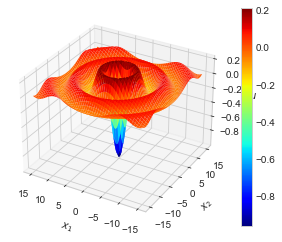

In [90]:
# a. grids
x1_vec = np.linspace(-15,15,500)
x2_vec = np.linspace(-15,15,500)
x1_grid_sombrero,x2_grid_sombrero = np.meshgrid(x1_vec,x2_vec,indexing='ij')
sombrero_grid = _sombrero(x1_grid_sombrero,x2_grid_sombrero)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid_sombrero,x2_grid_sombrero,sombrero_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. colorbar
fig.colorbar(cs);

## Multi-start - BFGS
**Multi-start:** Draw many random starting values:

In [93]:
np.random.seed(1986)
x0s = -15 + 30*np.random.uniform(size=(5000,2)) # in [-15,15]
xs = np.empty((5000,2))
fd = np.empty(5000)

Try to solve with **BFGS** starting from each of these:

In [94]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s): # loop with counter
    
    # a. optimize
    result = optimize.minimize(sombrero,x0,method='BFGS')
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[1]:6.2f})',end='')
        print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) with f = {f:.14f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.14f}')

   0: x0 = (  2.07,-12.68) -> converged at (  2.26,-13.84) with f = -0.05118272212318
   1: x0 = (  3.25, 11.92) -> converged at (  3.69, 13.53) with f = -0.05118272211068
   2: x0 = (  1.35,  6.08) -> converged at (  1.67,  7.53) with f = -0.12241421149687
   3: x0 = ( -3.42,  4.55) -> converged at ( -4.63,  6.17) with f = -0.12241421149362
   4: x0 = (  5.70,  6.56) -> converged at (  5.06,  5.82) with f = -0.12241421149695
   5: x0 = (  5.71,  9.20) -> converged at (  4.06,  6.56) with f = -0.12241421146805
   6: x0 = ( -6.49,  7.73) -> converged at ( -4.96,  5.91) with f = -0.12241421149702
   7: x0 = ( -5.77, -1.86) -> converged at ( -7.34, -2.37) with f = -0.12241421135593
   8: x0 = (  1.58, -2.01) -> converged at (  0.04, -0.05) with f = -0.99776236017000
   9: x0 = (  2.33, 11.77) -> converged at (  2.72, 13.76) with f = -0.05118272212317
  25: x0 = (  1.41, -3.37) -> converged at (  0.03, -0.06) with f = -0.99776236017097
 150: x0 = (-14.53,  8.53) -> converged at ( -0.06,  0

The solver, wrongly, **converges to many of the local minima**:

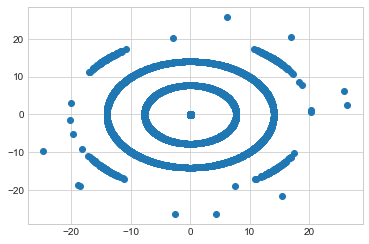

In [95]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]);

## Multi-start - Nelder-Mead
Try to solve with **Nelder-Mead** starting from each of these:

In [96]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(sombrero,x0,method='Nelder-Mead')
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[1]:6.2f})',end='')
        print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) with f = {f:.12f}')

# best solution
print(f'\nbest solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.12f}')

   0: x0 = (  2.07,-12.68) -> converged at (  2.20,-13.85) with f = -0.051182722123
   1: x0 = (  3.25, 11.92) -> converged at (  3.43, 13.60) with f = -0.051182722123
   2: x0 = (  1.35,  6.08) -> converged at (  1.39,  7.59) with f = -0.122414211497
   3: x0 = ( -3.42,  4.55) -> converged at ( -3.71,  6.76) with f = -0.122414211497
   4: x0 = (  5.70,  6.56) -> converged at (  6.69,  3.84) with f = -0.122414211497
   5: x0 = (  5.71,  9.20) -> converged at (  4.98, 13.11) with f = -0.051182722123
   6: x0 = ( -6.49,  7.73) -> converged at ( -7.34,  2.37) with f = -0.122414211497
   7: x0 = ( -5.77, -1.86) -> converged at ( -7.45, -2.01) with f = -0.122414211497
   8: x0 = (  1.58, -2.01) -> converged at ( -0.02,  0.06) with f = -0.997762360171
   9: x0 = (  2.33, 11.77) -> converged at (  2.36, 13.83) with f = -0.051182722123

best solution:
 x = ( -0.02,  0.06) -> f = -0.997762360171


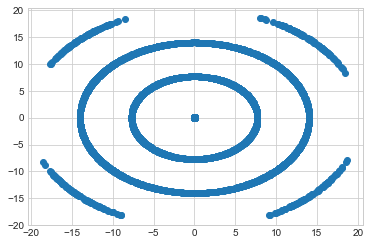

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]);

# Griewank function: Local minima and multistart

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+2$$

The **global minimum** of this function is $f(0,0) = 0$. But the function also have a lot of **local minima**. How to avoid these?

In [99]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(1))
    return A-B+1

Test global minimum:

In [100]:
griewank(np.zeros(2))

0.0

## 3D plot

In [-600,600] x [-600,600]:


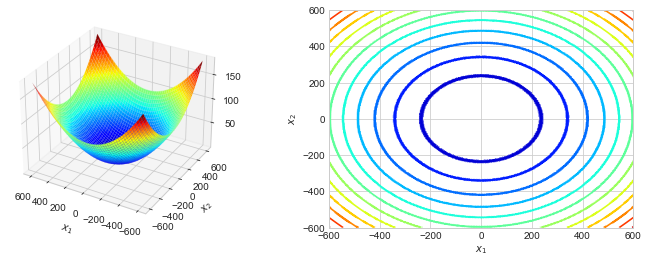

In [-5,5] x [-5,5]:


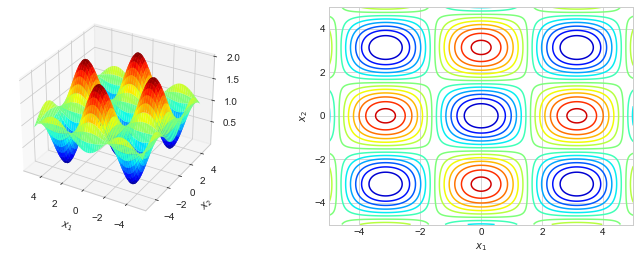

In [-1,1] x [-1,1]:


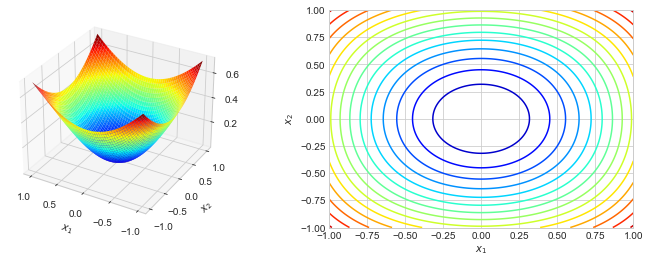

In [101]:
for bound in [600,5,1]:
    
    print(f'In [{-bound},{bound}] x [{-bound},{bound}]:')
    
    # a. grids
    x1_vec = np.linspace(-bound,bound,1000)
    x2_vec = np.linspace(-bound,bound,1000)
    x1_grid_griewank,x2_grid_griewank = np.meshgrid(x1_vec,x2_vec,indexing='ij')
    griewank_grid = griewank_(x1_grid_griewank,x2_grid_griewank)

    # b. main
    fig = plt.figure(figsize=(12,4))
    
    # 3D
    ax = fig.add_subplot(1,2,1,projection='3d')
    cs = ax.plot_surface(x1_grid_griewank,x2_grid_griewank,griewank_grid,cmap=cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.invert_xaxis()
    
    # contour
    ax = fig.add_subplot(1,2,2)
    cs = ax.contour(x1_vec,x2_vec,griewank_grid,levels=15,cmap=cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    plt.show()

## Multi-start

**Multi-start:** Draw many random starting values:

In [102]:
np.random.seed(1986)
x0s = -600 + 1200*np.random.uniform(size=(5000,2)) # in [-600,600] change to [-200,200] by having -200 + 400*np....
xs = np.empty((5000,2))
fs = np.empty(5000)

In [103]:
x0s.shape # big array # so first guess will be x0[0:], and then x0[1:]

(5000, 2)

Try to solve with **BFGS** starting from each of these:

In [104]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(griewank,x0,method='BFGS',tol=1e-8)
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:7.2f},{x0[1]:7.2f})',end='')
        print(f' -> converged at ({xs[i][0]:7.2f},{xs[i][1]:7.2f}) with f = {f:12.8f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')

   0: x0 = (  82.65,-507.19) -> converged at (  81.64,-508.68) with f =  66.38903667
   1: x0 = ( 130.18, 477.00) -> converged at ( 131.88, 477.28) with f =  61.32846302
   2: x0 = (  53.89, 243.27) -> converged at (  53.38, 241.78) with f =  15.33462113
   3: x0 = (-136.64, 181.99) -> converged at (-138.16, 182.12) with f =  13.07067667
   4: x0 = ( 228.06, 262.36) -> converged at ( 229.22, 260.62) with f =  30.13156447
   5: x0 = ( 228.22, 368.17) -> converged at ( 229.22, 367.38) with f =  46.90141331
   6: x0 = (-259.50, 309.21) -> converged at (-141.30, 279.46) with f =  24.52846525
   7: x0 = (-230.91, -74.51) -> converged at (-232.36, -75.36) with f =  14.92523628
   8: x0 = (  63.24, -80.57) -> converged at (  62.80, -81.64) with f =   2.65359622
   9: x0 = (  93.14, 470.65) -> converged at (  94.20, 471.00) with f =  57.70816887
  25: x0 = (  56.57,-134.77) -> converged at (  53.38,  -3.14) with f =   0.71518870
  57: x0 = ( -28.14,  -4.62) -> converged at ( -28.26,  -3.14) wi

The solver, wrongly, **converges to many of the local minima**:

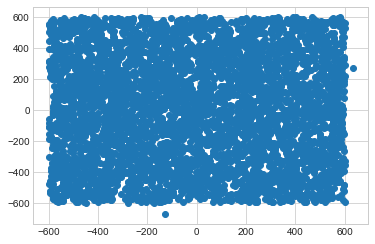

In [105]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]); # all points it converges to (almost any point)

## Is there a better solution than multi-start?

**In short:** No. But we could draw numbers between -200,200, cause solution is not in the corners!

**Potential improvement:** Use information from previous run to determine, where to look next. Fundamental trade-off between:

1. **Exploitation.** Focus on areas where previous evaluations returned low function values.
2. **Exploration.** Focus on completely new areas. 

**Heuristic:** If the same optimum is obtained for many starting values, this is a good sign for it being the global optimum.

**Further discussion**: [Benchmarking Global Optimizers](https://fguvenendotcom.files.wordpress.com/2019/09/agk2019-september-nber-submit.pdf) ([code](https://github.com/serdarozkan/TikTak#tiktak))

# Constraints
## In general

Consider the **constrained problem**:
$$
\min_{x_1,x_2,x_3,x_4} x_1x_4(x_1+x_2+x_3) + x_3
$$

subject to

$$
\begin{aligned}
x_1x_2x_3x_4 &\geq 25 \\
x_1^2+x_2^2+x_3^2+x_4^2 &= 40 \\
1 \leq x_1,x_2,x_3,x_4 &\leq 5
\end{aligned}
$$

Define **objective** and **constraints**:

In [ ]:
def _objective(x1,x2,x3,x4):
    return x1*x4*(x1+x2+x3)+x3

def objective(x):
    return _objective(x[0],x[1],x[2],x[3]) # define in terms of vector

def ineq_constraint(x):
    return x[0]*x[1]*x[2]*x[3]-25.0 # violated if negative

def eq_constraint(x):
    sum_eq = 40.0
    for i in range(4):
        sum_eq = sum_eq - x[i]**2
    return sum_eq # must equal zero

In [ ]:
# a. setup
bound = (1.0,5.0)
bounds = (bound, bound, bound, bound) # tuple containing bound for each variable
ineq_con = {'type': 'ineq', 'fun': ineq_constraint} 
eq_con = {'type': 'eq', 'fun': eq_constraint}

# b. call optimizer
x0 = (40**(1/8),40**(1/8),40**(1/8),40**(1/8)) # <-- initial guess that fits the equality constraint

result = optimize.minimize(objective,x0,
                             method='SLSQP', # only SLSQP can do general constraints
                             bounds=bounds,
                             constraints=[ineq_con,eq_con],
                             options={'disp':True})

print('\nx = ',result.x)

**Alternative:** Extend the **objective function with a penalty term**, where guesses outside the allowed bounds and constraints are projected into the allowed region, but a (large) penalty term is added to discourage this. Solve this problem with an unconstrained solver.

## Economic application
Consider the following **consumption-saving problem**:

$$
\begin{aligned}
V(a_0) &= \max_{c_1,c_2,c_3} \frac{c_{1}^{1-\rho}}{1-\rho} + \beta \frac{c_{2}^{1-\rho}}{1-\rho} + \beta^2\frac{c_{3}^{1-\rho}}{1-\rho} + \beta^2\nu\frac{(a_{3}+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
&\text{s.t.}&\\
m_1 &= (1+r)a_0 + y_1\\
a_1 &= m_1-c_1\\
m_2 &= (1+r)a_1 + y_2\\
a_2 &= m_2-c_2\\
m_3 &= (1+r)a_2 + y_3\\
a_3 &= m_3-c_3\\
c_1,c_2,c_3 &\geq 0\\
a_1,a_2,a_3 &\geq 0\\
\end{aligned}
$$

where 

* $m_t$ is cash-on-hand in period $t\in\{1,2,\dots,T\}$
* $c_t$ is consumption $t$
* $a_t$ is end-of-period assets and income in period $t$
* ${y_t}$ is income in period $t$
* $\beta > 0$ is the discount factor
* $r > -1$ is the interest rate 
* $\rho > 1$ is the CRRA coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_t\geq0$ is a no-borrowing constraint.

**Guide to solve such problem:**

1. Setup parameters
2. Formulate objective function
3. Determine how to handle constraints
4. Call optimizer

**Parameters:**

In [2]:
par = SimpleNamespace()
par.a0 = 0.5
par.beta = 0.94
par.r = 0.04
par.rho = 8
par.kappa = 0.5
par.nu = 0.1
par.T = 3
#par.borrowing_limit = 1
par.y = np.arange(1,par.T+1) # = [1,2,3]

**Objetive function:**

In [3]:
def evaluate(c,par,penalty_factor=10_000):
    """ evaluate model and calculate utility and penalty if constraints are not satisfies """
    
    # a. allocate
    a = np.zeros(par.T) # end-of-period assets
    m = np.zeros(par.T) # cash-on-hand
    cb = np.zeros(par.T) # bounded
    
    # b. bound consumption and penalty
    penalty = 0.0
    for t in range(par.T): # period-by-period 
        
        # i. lagged assets
        a_lag = a[t-1] if t > 0 else par.a0
        
        # ii. cash-on-hand
        m[t] = (1+par.r)*a_lag + par.y[t]
        
        # ii. bound consumption
        if c[t] < 0.0: # too low
            cb[t] = 0.0
            penalty += penalty_factor*np.abs(c[t]-0.0)            
        elif c[t] > m[t]: # too high, if borrowing we could make c(t) > (m(t)+1))
            cb[t] = m[t]
            penalty += penalty_factor*np.abs(c[t]-m[t])
        else: # just fine
            cb[t] = c[t]
        
        # d. end-of-period assets 
        a[t] = m[t] - cb[t]
            
    # c. utility
    total_utility = 0.0
    
    # i. consumption
    for t in range(par.T):
        discounting = par.beta**t
        per_period_utility = cb[t]**(1-par.rho)/(1-par.rho)
        total_utility += discounting*per_period_utility
    
    # ii. bequest
    discounting = par.beta**(par.T-1)
    bequest_utility = par.nu*(a[-1]+par.kappa)**(1-par.rho)/(1-par.rho)
    total_utility += discounting*bequest_utility
        
    # d. return
    return total_utility,penalty,m,a
    
def obj(c,par,penalty_factor=10_000):
    """ gateway to evaluate() for optimizer """
    
    utility,penalty,_m,_a = evaluate(c,par,penalty_factor)
    
    return -utility + penalty

**Solve:**

In [4]:
def solve(par,tol=1e-8):
    
    # a. initial geuss
    x0 = par.a0/par.T*np.ones(par.T)
    
    # b. solve
    t0 = time.time()
    results = optimize.minimize(obj,x0,args=(par,),method='Nelder-Mead',options={'xatol':tol,'fatol':tol,'maxiter':50_000})
    
    if not results.success:
        print(results)
        raise ValueError
    
    print(f'solved model in {time.time()-t0:.3f} secs [{results.nit} iterations, {results.nfev} function evaluations]\n')
    
    # c. details
    c = results.x
    total_utility,penalty,m,a = evaluate(c,par)
    assert np.isclose(penalty,0.0)
    
    print(f't =  0: a = {par.a0:.4f}')
    for t in range(par.T):
        print(f't = {t+1:2d}: y = {par.y[t]:7.4f}, m = {m[t]:7.4f}, c = {c[t]:7.4f}, a = {a[t]:7.4f} ')    
    
    print(f'\ntotal utility = {total_utility:.8f} [penalty = {penalty:.4f}]\n')
    
    for t in range(par.T):
        
        if t < par.T-1:
            foc_error = c[t]**(-par.rho) - par.beta*(1+par.r)*c[t+1]**(-par.rho)
        else:
            foc_error = c[t]**(-par.rho) - par.nu*(a[t]+par.kappa)**(-par.rho)
            
        print(f'FOC error in period {t+1:2d}: {foc_error:12.8f}')
    

In [5]:
solve(par)

solved model in 0.034 secs [306 iterations, 561 function evaluations]

t =  0: a = 0.5000
t =  1: y =  1.0000, m =  1.5200, c =  1.5200, a =  0.0000 
t =  2: y =  2.0000, m =  2.0000, c =  2.0000, a =  0.0000 
t =  3: y =  3.0000, m =  3.0000, c =  2.0001, a =  0.9999 

total utility = -0.01039479 [penalty = 0.0000]

FOC error in period  1:   0.03127676
FOC error in period  2:   0.00008879
FOC error in period  3:   0.00000134


**What happens if the income path is reversed?**

In [6]:
par.y = list(reversed(par.y))
solve(par)

solved model in 0.026 secs [193 iterations, 354 function evaluations]

t =  0: a = 0.5000
t =  1: y =  3.0000, m =  3.5200, c =  1.9145, a =  1.6055 
t =  2: y =  2.0000, m =  3.6698, c =  1.9090, a =  1.7607 
t =  3: y =  1.0000, m =  2.8312, c =  1.9036, a =  0.9275 

total utility = -0.00540710 [penalty = 0.0000]

FOC error in period  1:   0.00000000
FOC error in period  2:  -0.00000000
FOC error in period  3:   0.00000000


**Question I:** Could we easily allowing for borrowing, i.e.

$$
\begin{aligned}
V(a_0) &= \max_{c_1,c_2,c_3} \frac{c_{1}^{1-\rho}}{1-\rho} + \beta \frac{c_{2}^{1-\rho}}{1-\rho} + \beta^2\frac{c_{3}^{1-\rho}}{1-\rho} + \beta^2\nu\frac{(a_{3}+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
&\text{s.t.}&\\
m_1 &= (1+r)a_0 + y_1\\
a_1 &= m_1-c_1\\
m_2 &= (1+r)a_1 + y_2\\
a_2 &= m_2-c_2\\
m_3 &= (1+r)a_2 + y_3\\
a_3 &= m_3-c_3\\
c_1,c_2,c_3 &\geq 0\\
a_1,a_2 &\geq -\lambda\\
a_3 &\geq 0
\end{aligned}
$$

**Question II:** Could we easily extend the problem to more periods?

$$
\begin{aligned}
V(a_0) &= \max_{c_1,c_2,\dots c_T} \sum_{t=1}^T \beta^{t-1} \frac{c_{t}^{1-\rho}}{1-\rho} + \beta^{T+1}\nu\frac{(a_{T}+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
&\text{s.t.}&\\
m_t &= (1+r)a_{t-1} + y_t\\
c_t &\geq 0\\
a_t &\geq 0
\end{aligned}
$$

**Follow-up question:** What is the problem for $T \rightarrow \infty$?

# Interpolation

**Intermezzo:** To consider dynamic optimization problems, we need to think about interpolation.

**Inputs:**

1. Sorted vector of known points (grid vector), $G = \{G_i\}_{i=0}^{n-1}$
2. Vector of known values (at these points), $F = \{F_i = f(G_i)\}_{i=0}^{n-1}$
3. A new point, `x`

**Algorithm:** `linear_interpolate()`
1. Determine `i`  such that

$$
G_i \leq x < G_{i+1}
$$

- that is we find value $G_i$ which lie between our 2 known data points

2. Compute interpolated value by
- because we know that for a straight line the slope is constant and given by $\frac{dy}{dx}=\frac{F_{i+1} - F_{i}}{G_{i+1} - G_i}$
- therefore we have that slope between point $(G_i,F_i)$ and $(G_{i+1},F_{i+1})$ is the same as slope between $(G_i,F_i)$ and $(x,y)$:

$$ 
\frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}} = \frac{y - F_{i}}{x-G_{i}}
$$
Now solving for y given certain x value:
$$
\Leftrightarrow y - F_{i} = \frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}}(x-G_{i}) \\
\Leftrightarrow y =  F_{i} + \frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}}(x-G_{i})
$$

**Extrapolation (prediction based outside of data points):**

1. Below where $x < G_1$: 

$$
y =  F_{0} + \frac{F_{1}-F_{0}}{G_{1}-G_{0}}(x-G_{0})
$$

2. Above where $x > G_{n-2}$: 

$$
y =  F_{n-2} + \frac{F_{n-1}-F_{n-2}}{G_{n-1}-G_{n-2}}(x-G_{n-2})
$$

In [106]:
def linear_interpolate(G,F,x):
    """ linear interpolation (and extrapolation)
    
    Args:
    
        G (np.ndarray): known points
        F (np.ndarray): known values
        x (float): point to be interpolated
        
    Returns:
    
        y (float): intepolated value
    
    """
    # make sure number of x values are equal to number of function values
    assert len(G) == len(F) # immidiately raise error if condition not met
    n = len(G)
    
    # a. find index in known points
    if x < G[1]: # exprapolation below
        i = 0 
    elif x > G[-2]: # extrapolation above
        i = n-2
    else: # true interpolation
        
        # search
        i = 0 
        while x >= G[i+1] and i < n-1: 
            i += 1
        
        assert x >= G[i]
        assert x < G[i+1]

    # b. interpolate
    diff_G = G[i+1]-G[i]
    diff_F = F[i+1]-F[i]
    slope = diff_F/diff_G
    y = F[i] + slope*(x-G[i])
    
    return y

## Example

Consider the following function and known points:

In [194]:
f = lambda x: (x-3)**3 - 3*x**2 + 5*x

G = np.linspace(-5,10,6) # grid points, if we increase 6 to e.g. 60 we get interpolated value closer to true value (more points smaller errors)
F = f(G) # function evaluated on grid

**Simple test:**

In [195]:
for x in [-2.3,4.1,7.5,9.1]:
    true = f(x)
    y = linear_interpolate(G,F,x) # interpolated value
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

x = -2.3 -> true = -176.2, interpolated = -193.5
x =  4.1 -> true =  -28.6, interpolated =  -27.7
x =  7.5 -> true =  -40.1, interpolated =  -24.5
x =  9.1 -> true =   24.1, interpolated =   50.7


**Scipy.interpolate:** Use the *RegularGridInterpolator*  

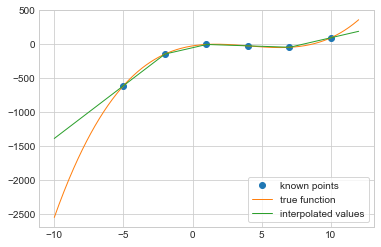

In [199]:
# a. construct interpolation function
interp_func = interpolate.RegularGridInterpolator([G],F,
                                                  bounds_error=False,
                                                  fill_value=None) # <-- note [] ensures it interpretes G as vector and not value
# bounds_error=False and fill_value=None allow for extrapolation

# b. interpolate
grid = np.linspace(-10,12,500)
interp_values = interp_func(grid)

# c. evaluate true values
true_values = f(grid)

# d. plot true and interpolated values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'o',label='known points')
ax.plot(grid,true_values,'-',lw=1,label='true function')
ax.plot(grid,interp_values,'-',lw=1,label='interpolated values')
ax.legend(loc='lower right',facecolor='white',frameon=True);

**Note:**

1. Linear interpolation works best when the function does not curve too much.
2. Extrapolation is much worse than interpolation.
    - check for example below -5 we extrapolate (= shitty)

**Multiple dimensions:** Same principle, ``interpolate.RegularGridInterpolator([G1,G2,G3],F)``.

# Dynamic optimization problems

The following subject is hard. But also extremely useful. *If you master this, you can solve (almost) all economic models you meet on your way in life*.

## Problem formulation

Consider a **household** living in two periods.

In the **second period** it gets utility from **consuming** and **leaving a bequest** (warm glow giving),

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand 
* $c_2$ is consumption
* $a_2$ is end-of-period assets 
* $\rho > 1$ is the risk aversion coefficient (curvature parameter)
    - higher $\rho$ implies that marginal utility falls faster with consumption in period 2--> more smoothing and hence lower rate of consumption in period 2
* $\nu > 0 $ is the strength of the bequest motive
    - implies decrease of consumption in period 2
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_2\geq0$ ensures the household *cannot* die in debt

Note, that there is a key trade-off: 
   - delaying consumption is constly because of the discount factor
   - but delaying some consumption is also attractive due to $u$ being concave (implies diminishing marginal utility)
       - value from consumption smoothing     

The **value function** $v(m_2)$ measures the household's value of having $m_2$ at the beginning of period 2.

In [32]:
# obeying the principle of "Do One Thing"
def utility(c,par): # <-- CRRA
    return c**(1-par.rho) / (1-par.rho)

def bequest(m,c,par):
    return par.nu*(m-c+par.kappa)**(1-par.rho) / (1-par.rho)

def v_last_period(c,m,par): # <-- value function
    return utility(c,par) + bequest(m,c,par)

In the **first period**, the household gets utility from consuming and takes into account that it will also live in the next-period, where it receives a stochastic income,

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1&=m_1-c_1\\
m_2&= (1+r)(m_1-c_1)+y_2 \\
y_{2}&= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

where

* $m_1$ is cash-on-hand in period 1
* $c_1$ is consumption in period 1
* $a_1$ is end-of-period assets in period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y_2$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the interest rate
* $a_1\geq0$ ensures the household *cannot* borrow

In [7]:
def v(c,m,par,v_plus_interp):
    
    # a. expected value
    v_plus = 0.0 # <-- no exptected value to begin with
    
    # loop through different combination of p,y
    for p,y in [(par.p,1+par.Delta),((1.0-par.p,1-par.Delta))]: 
        
        # i. next period cash-on-hand
        a = m-c
        m_plus = (1+par.r)*a + y
        
        # ii. next-period values
        v_plus_now = v_plus_interp([m_plus])[0] # interpolation
        
        # iii. probability weighted sum (aggregation)
        v_plus += p*v_plus_now # <-- remember expected value is [(1-p)*E_1+p*E_1]/2
    
    # b. total value
    return utility(c,par) + par.beta*v_plus

## Solve household problem

Choose **parameters**:

In [33]:
par = SimpleNamespace()

# preferences
par.rho = 8.0
par.nu = 0.1
par.kappa = 0.5
par.beta = 0.94

# return and income
par.r = 0.04
par.p = 0.5
par.Delta = 0.5

# grid (what levels of cash on hand do we want to solve for)
par.Nm = 500 # number of grid points for m
par.m_min = 1e-4 # minimum value for m
par.m_max = 5.0 # maximum value for m

**Solve second period:**

In [34]:
def solve_last_period(par):

    # a. allocate
    m_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    c_func = np.empty(par.Nm)

    # b. solve
    for i,m in enumerate(m_grid):

        # i. objective
        obj = lambda x: -v_last_period(x[0],m,par) # <-- remember negation due to minimization optimizer

        # ii. optimizer
        x0 = m/2 # initial value guess
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m),)) # bounds does not allow for borrowing!

        # iii. save function value and choice
        v_func[i] = -result.fun
        c_func[i] = result.x
        
    return m_grid,v_func,c_func

**Solve:**

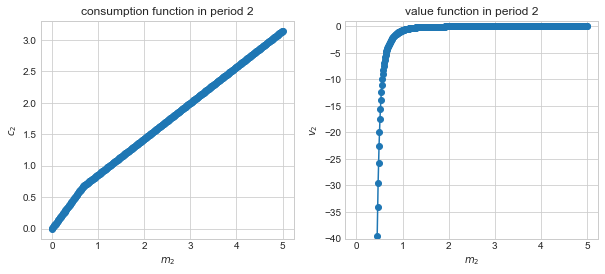

In [35]:
m2_grid,v2_func,c2_func = solve_last_period(par)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_grid,c2_func,'-o')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_grid,v2_func,'-o')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([-40,1]);

**Note:** We now solve for the consumption function, rather than a specific optimum.

**Question:** Why is there a kink in the consumption function?

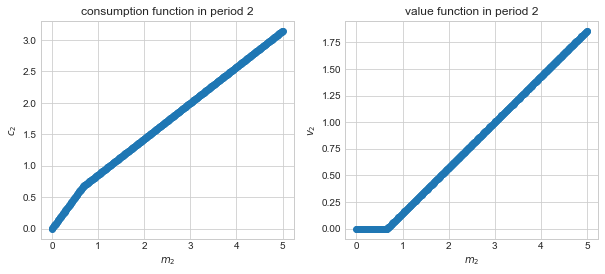

In [36]:
m2_grid,v2_func,c2_func = solve_last_period(par)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_grid,c2_func,'-o')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_grid,m2_grid-c2_func,'-o')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2');
#ax.set_ylim([-40,1]);

- We do not save if low

**Construct interpolator:**

In [37]:
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid],v2_func,bounds_error=False,fill_value=None) # [] to get all grid points

**Solve first period:**

In [38]:
def solve_single_period(par,v_plus_interp):

    # a. allocate
    m_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    c_func = np.empty(par.Nm)
    
    # b. solve
    for i,m in enumerate(m_grid):
        
        # i. objective (value function for period 1)
        obj = lambda x: -v(x[0],m,par,v_plus_interp)
        
        # ii. solve
        x0 = m/2 # initial guess
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m),))
        
        # iv. save
        v_func[i] = -result.fun
        c_func[i] = result.x[0]
     
    return m_grid,v_func,c_func

**Solve:**

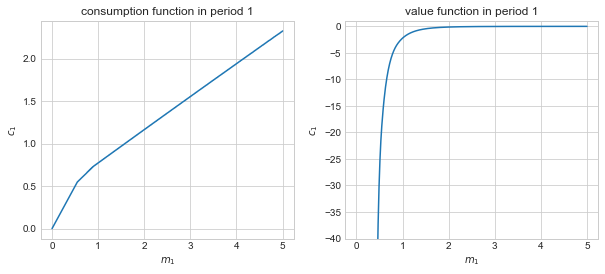

In [39]:
m1_grid,v1_func,c1_func = solve_single_period(par,v2_func_interp)

# illustrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_grid,c1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(m1_grid,v1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_ylim([-40,1]);

**Summary:** We can summarize what we have done in a single function doing:

1. Solve period 2 (i.e. find $v_2(m_2)$ og $c_2(m_2)$)
2. Construct interpolator of $v_2(m_2)$
3. Solve period 1 (i.e. find $v_1(m_1)$ og $c_1(m_1)$)

In [40]:
def solve(par):
    
    # a. solve period 2
    m2_grid,v2_func,c2_func = solve_last_period(par)
    
    # b. construct interpolator
    v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func,
        bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_grid,v1_func,c1_func = solve_single_period(par,v2_func_interp)
    
    return m1_grid,c1_func,m2_grid,c2_func

### Plot consumption function for various level of income risk, i.e varios $\Delta$

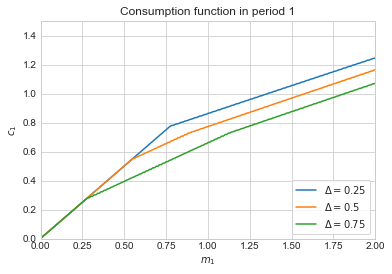

In [220]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_Delta = par.Delta
for Delta in [0.25,0.50,0.75]:
    par.Delta = Delta
    m1_grid,c1_func,m2_grid,c2_func = solve(par)
    ax.plot(m1_grid,c1_func,label=f'$\Delta = {Delta}$')
    par.Delta = _Delta # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('Consumption function in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

**Main takeaway:** The household lower its consumption when risk increases (such as in a recession). This is called **precautionary saving**.

### Increasing the number of periods

In [224]:
def solve_many_periods(par):
    
    t0 = time.time()
    
    # a. allocate
    m = np.zeros((par.T,par.Nm))
    v = np.zeros((par.T,par.Nm))
    c = np.zeros((par.T,par.Nm))
    
    # b. iterate
    for t in reversed(range(par.T)): # loop backwards
        
        t0_ = time.time()
        
        # in last period we solve the problem
        if t == par.T-1:
            
            m[t,:],v[t,:],c[t,:] = solve_last_period(par)
        
        # if not last period we use interpolator and then solve problem
        else:
    
            # i. construct interpolator
            v_plus_interp = interpolate.RegularGridInterpolator([m[t+1,:]],v[t+1,:],
                bounds_error=False,fill_value=None)
    
            # ii. solve period
            m[t,:],v[t,:],c[t,:] = solve_single_period(par,v_plus_interp)
        
        print(f'period {t} solved in {time.time()-t0_:5.1f} secs')
        
    print(f'model solved in {time.time()-t0:5.1f} secs')
    
    return m,c

**Solve:**

In [222]:
par.T = 10
m_grids,c_funcs = solve_many_periods(par)

period 9 solved in   0.5 secs
period 8 solved in   2.8 secs
period 7 solved in   2.5 secs
period 6 solved in   2.5 secs
period 5 solved in   2.5 secs
period 4 solved in   2.5 secs
period 3 solved in   2.5 secs
period 2 solved in   2.4 secs
period 1 solved in   2.1 secs
period 0 solved in   2.3 secs
model solved in  22.6 secs


**Plot:**

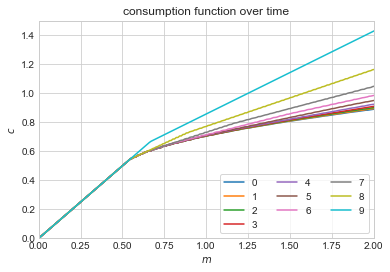

In [223]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for t in range(par.T):
    ax.plot(m_grids[t,:],c_funcs[t,:],label=f'{t}')

ax.legend(loc='lower right',facecolor='white',ncol=3,frameon=True)
ax.set_xlabel('$m$')
ax.set_ylabel('$c$')
ax.set_title('consumption function over time')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

## Simulation

**Step 1:** Solve and construct interpolators:

In [ ]:
c_interps = []
for t in range(par.T):
    c_interp = interpolate.RegularGridInterpolator([m_grids[t,:]],c_funcs[t,:],bounds_error=False,fill_value=None)
    c_interps.append(c_interp)


**Step 2:** Draw initail distribution of $m_1$ and simulate forward

In [ ]:
# a. allocate
simN = 10_000

sim_m = np.zeros((par.T,simN))
sim_y = np.zeros((par.T,simN))
sim_c = np.zeros((par.T,simN))
sim_a = np.zeros((par.T,simN))

# b. simulate
a0 = np.random.exponential(size=simN) # arbitrary choice of distribution
for t in range(par.T):
    
    # i. lagged assets
    if t == 0:
        a_lag = a0
    else:
        a_lag = sim_a[t-1,:]
    
    # ii. income
    p_vec = [par.p,1-par.p]
    y_vec = [1+par.Delta,1-par.Delta]
    sim_y[t,:] = np.random.choice(y_vec,p=p_vec,size=simN)
    
    # iii. cash-on-hand
    sim_m[t] = (1+par.r)*a_lag + sim_y[t,:]
    
    # iv. consumption-saving
    sim_c[t,:] = c_interps[t](sim_m[t,:])
    sim_a[t,:] = sim_m[t,:]-sim_c[t,:]

**Step 3:** Plot distributions

In [ ]:
for t in range(-1,par.T):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    bins = np.linspace(0,5,100)
    if t == -1:
        ax.hist(np.fmin(a_lag,5),bins=bins)
    else:
        ax.hist(np.fmin(sim_a[t,:],5),bins=bins)
        
    ax.set_title(f'assets, t = {t+1}')
    ax.set_xlabel('$a_t$')
    ax.set_ylabel('freq.')
    ax.set_xlim([0,5])

We see that towards end of life the saving falls.

**Conclusion:** You can now solve models with complex heterogeneity and uncertainty, and simulate the implied dynamics. By introducing various policies you can quantify their effect not just for the average, but for the full distribution.